In [4]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-19 14:29:56.871876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [7]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [8]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*.npy"))

In [9]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*.npy"))

In [10]:
filename_valid = filename_neg_valid + filename_pos_valid

In [11]:
for name in filename_neg_train:
    m = np.sum(np.load(filename_pos_valid[3], allow_pickle=True)[()]['code'])
    if m > 0:
        print(name)

In [12]:
#ind_pick_from_batch = [2, 11, 17, 18]

L_vars = 4
L_vars_h = 4
L_vars_ori = 19

In [13]:
L_valid = len(filename_valid)

TEST_input = np.empty((L_valid, 4, 64))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    
    collection = np.load(name, allow_pickle=True)[()]
    
    vector_gn2 = collection['Gn2']
    vector_gn1 = collection['Gn1']
    vector_gp0 = collection['Gp0']
    vector_gp1 = collection['Gp1']
     
    TEST_input[i, 0, :] = vector_gn2
    TEST_input[i, 1, :] = vector_gn1
    TEST_input[i, 2, :] = vector_gp0
    TEST_input[i, 3, :] = vector_gp1
    
    if 'pos' in name:
        TEST_target[i] = 1.0
    else:
        TEST_target[i] = 0.0

In [14]:
prob_base = np.sum(TEST_target) / len(TEST_target)

In [15]:
prob_base

0.003781148922600337

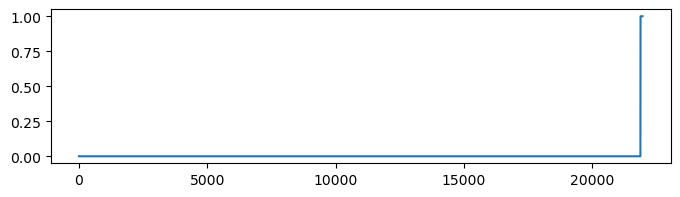

In [16]:
plt.figure(figsize=(8, 2))
plt.plot(TEST_target)

**ConvNext**

In [17]:
from sklearn.metrics import brier_score_loss

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI

    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    BS = brier_score_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{} {} {} {}'.format(CSI, AUC, freq, BS))
    metric = AUC_metric + 2*BS


    return metric


# def verif_metric(VALID_target, Y_pred, prob_base):
#     BS = np.mean((Y_pred.ravel()-VALID_target.ravel())**2)
#     BSS = 1-(BS/prob_base)
#     print('BS = {}; BSS = {}'.format(BS, BSS))
#     return BS/prob_base

In [18]:
from tensorflow.keras import Model

In [97]:
IN = tf.keras.Input(shape=(4, 64))

X = IN

X = tf.keras.layers.Conv1D(64, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(128, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

#X = tf.keras.layers.Dropout(0.1)(X)

X = tf.keras.layers.Conv1D(256, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(512, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(1024, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.GlobalMaxPool1D()(X)

OUT = X

OUT = layers.Dense(256)(OUT)
OUT = layers.Activation("gelu")(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6)(OUT)

OUT = layers.Dense(1,)(OUT)

model = Model(inputs=IN, outputs=OUT)

In [98]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience
epochs = 500
L_train = 100
batch_size = 100
batch_size_half = 50

In [152]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'SEQ_S'

model_name = '{}_pp4_tune17'.format(key)
model_path = temp_dir+model_name

W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'SEQ_S_pp4_tune16')

for l in range(len(W_new)):
    if W_new[l].shape == W_old[l].shape:
        W_new[l] = W_old[l]

model.set_weights(W_new)


In [153]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-6))

In [ ]:
X_batch = np.empty((batch_size, 4, 64))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [145]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [146]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record_temp = verif_metric(TEST_target, Y_pred)
record = record_temp
print("Initial record: {}".format(record))

0.04964539007092199 0.8823568464455958 0.7831325301204819 0.011317526395040783
Initial record: 0.14027820634448582


In [147]:
#verif_metric(TEST_target, Y_pred, thres=0.5)

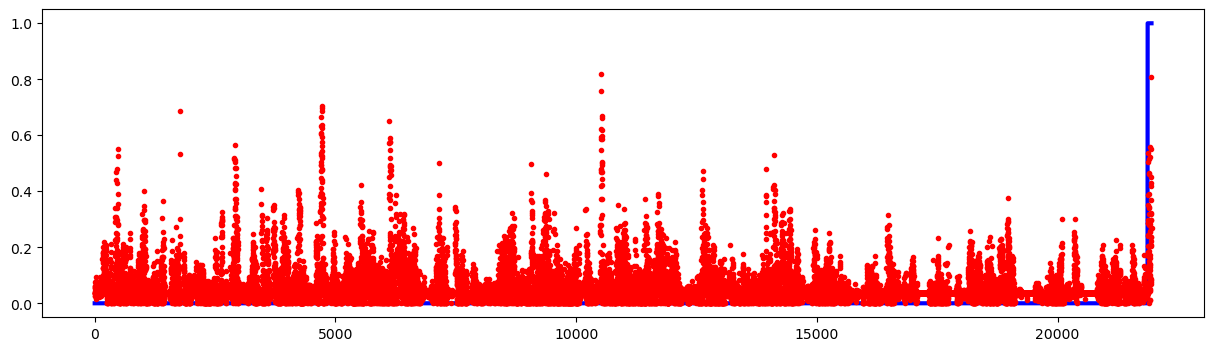

In [151]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target[:], 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r.')
#plt.plot(Y_pred>0.5)

In [149]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [150]:
# ========== Training loop ========== #



for i in range(epochs):
    

    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_neg_train)
        shuffle(filename_pos_train)
        
        N_aug = 18 #int(np.random.uniform(4, 40))
        N_storm = 100 - N_aug

        L_storm = len(filename_neg_train)
        L_aug = len(filename_pos_train)
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            collection = np.load(file_pick[k], allow_pickle=True)[()]
    
            vector_gn2 = collection['Gn2']
            vector_gn1 = collection['Gn1']
            vector_gp0 = collection['Gp0']
            vector_gp1 = collection['Gp1']
            
            X_batch[k, 0, :] = vector_gn2
            X_batch[k, 1, :] = vector_gn1
            X_batch[k, 2, :] = vector_gp0
            X_batch[k, 3, :] = vector_gp1

            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.7, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.02)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0.0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.5):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04929577464788732 0.8820805446038774 0.7951807228915663 0.012064578364539232
Validation loss 0.14204861212520103 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.050724637681159424 0.8786919215181561 0.7469879518072289 0.011117229389714942
Validation loss 0.14354253726127378 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.046875 0.8774387838531739 0.6144578313253012 0.010080639524650428
Validation loss 0.14272249519612698 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04065040650406504 0.877563849691798 0.5421686746987951 0.008860617521440708
Validation loss improved from 0.14027820634448582 to 0.1401573853510834
save to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune16
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune16/assets
--- 14.341151475906372 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04 0.8770933376821719 0.5662650602409639 0.009542818634926871
Validation loss 0.14199229958768184 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.046511627906976744 0.8767382498716285 0.6265060240963856 0.01037043375409738
Validation loss 0.14400261763656624 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03305785123966942 0.8769222674491637 0.5060240963855421 0.008413911567289137
Validation loss improved from 0.1401573853510834 to 0.1399055556854146
save to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune16
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune16/assets
--- 14.39514708518982 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047244094488188976 0.874390097430145 0.6024096385542169 0.009762187667391831
Validation loss 0.1451342779046387 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03937007874015748 0.8741771549339851 0.5903614457831325 0.00966431764523431
Validation loss 0.14515148035648356 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047244094488188976 0.8739576010278538 0.6024096385542169 0.009713697073074937
Validation loss 0.14546979311829608 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04032258064516129 0.874118754145905 0.5542168674698795 0.008986808527439882
Validation loss 0.14385486290897476 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047619047619047616 0.8737611870566222 0.5903614457831325 0.009415190621780256
Validation loss 0.1450691941869383 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047244094488188976 0.8735934225286 0.6024096385542169 0.009661237640695396
Validation loss 0.14572905275279086 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04032258064516129 0.8735234517730699 0.5542168674698795 0.009008486422262119
Validation loss 0.14449352107145436 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.046875 0.8732113381273401 0.6144578313253012 0.009863420857378272
Validation loss 0.14651550358741647 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.046875 0.8730865477641313 0.6144578313253012 0.009832169676035207
Validation loss 0.1465777915879391 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047619047619047616 0.8732730446204058 0.5903614457831325 0.009114471026964919
Validation loss 0.14495589743352405 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.046875 0.8730970158299193 0.6144578313253012 0.009567572926761662
Validation loss 0.14603813002360405 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.046511627906976744 0.8728711259892323 0.6265060240963856 0.009905327375011819
Validation loss 0.1469395287607913 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04032258064516129 0.8726840781821268 0.5542168674698795 0.008506034388422254
Validation loss 0.1443279905947177 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047244094488188976 0.8730760796983434 0.6024096385542169 0.009079749333886718
Validation loss 0.14508341896943 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05426356589147287 0.8728281518244185 0.6385542168674698 0.00970179379575321
Validation loss 0.1465754357670879 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05426356589147287 0.8727540489376566 0.6385542168674698 0.009772939971955804
Validation loss 0.14679183100625498 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047244094488188976 0.8729455043514096 0.6024096385542169 0.009078707512546283
Validation loss 0.14521191067368297 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04032258064516129 0.8729303532035586 0.5542168674698795 0.008462191835461666
Validation loss 0.14399403046736473 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05263157894736842 0.8726174131315825 0.6867469879518072 0.010289444635189422
Validation loss 0.14796147613879637 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.046875 0.8726096998199492 0.6144578313253012 0.009287493815939666
Validation loss 0.14596528781193016 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0546875 0.872523751490322 0.6265060240963856 0.009403853841393571
Validation loss 0.14628395619246512 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05303030303030303 0.8724061234879155 0.6746987951807228 0.009900881825412353
Validation loss 0.14739564016290924 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05303030303030303 0.8724716866367977 0.6746987951807228 0.009762878537127446
Validation loss 0.14705407043745714 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047244094488188976 0.872440833390265 0.6024096385542169 0.009201484946207546
Validation loss 0.14596213650215006 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05185185185185185 0.8723138392237322 0.7108433734939759 0.010335900192368913
Validation loss 0.14835796116100564 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05263157894736842 0.8720163257750225 0.6867469879518072 0.010455285491887576
Validation loss 0.14889424520875263 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05185185185185185 0.8720325788245353 0.7108433734939759 0.010540354708123477
Validation loss 0.14904813059171163 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05303030303030303 0.871933683150381 0.6746987951807228 0.009889333213658397
Validation loss 0.1478449832769358 NOT improved


KeyboardInterrupt: 

In [ ]:
model.save(model_path)

In [ ]:
plt.plot(Y_batch)

0.07216494845360824 0.8547555871923765 1.5060240963855422 0.008271191126251975

Validation loss improved from 0.16323948442990924 to 0.16178679506012741

save to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5

INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5/assets

In [ ]:
import tf.keras.backend as K

In [ ]:
def custom_loss(y_true, y_pred):
            
    y_pred_neg = y_pred[y_true == 0]
    y_pred_pos = y_pred[y_true == 1]
    
    loss = 0.1*K.mean(y_pred_neg) + K.mean(K.abs(y_pred_pos-1))
        
    return loss